In [1]:
import numpy as onp
import jax.numpy as np
from jax import random, vmap
from jax.config import config
config.update("jax_enable_x64", True)

from scipy.optimize import minimize
from scipy import stats
from pyDOE import lhs
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.interpolate import griddata

from jaxbo.models import GP
from jaxbo.utils import normalize

import jaxbo.acquisitions as acquisitions
import jaxbo.utils as utils
from jaxbo.input_priors import uniform_prior

from sklearn import mixture
from pyDOE import lhs

onp.random.seed(1234)


In [2]:
def wheel_function(x, y, delta_control):
    # define the control parameter
    reward0 = 0.2
    reward1 = 1.0
    reward2 = 0.1
    reward3 = 0.05
    reward4 = 0.0
    
    # the number of modes in this direction
    r = np.sqrt(x**2 + y**2)
    if r < delta_control:
        return reward0
    elif (x >= 0) & (y >= 0):
        return reward1
    elif (x >= 0) & (y <= 0):
        return reward2
    elif (x <= 0) & (y >= 0):
        return reward3
    else:
        return reward4
    

In [3]:
class run_simulations:
    # Initialize the class
    def __init__(self, data_test, xs_in, sigma_in, T_in, MC_samples_in, XX, YY, Y_data_plot, nn, delta_control):
        
        # Initialize the model
        self.Data = data_test
        self.N_dim = self.Data.shape[0]
        
        self.xs = xs_in
        self.xs_plot = onp.asarray(xs_in)
        self.sigma = sigma_in
        self.T = T_in
        self.MC_samples = MC_samples_in
        self.delta = 0.1
        self.jitter = 1e-8
        self.N_init = 3
        
        self.XX = XX
        self.YY = YY
        self.Y_data_plot = Y_data_plot
        self.nn = nn
        self.delta_control = delta_control
        
        # define GP model and JAX GP options
        self.dim = xs_in.shape[1]
        self.lb = 0.0*np.ones(self.dim)
        self.ub = 1.0*np.ones(self.dim)
        self.bounds = {'lb': self.lb, 'ub': self.ub}
        self.p_x = uniform_prior(self.lb, self.ub)
        self.options = {'kernel': 'RBF', 'input_prior': self.p_x}
        self.gp_model = GP(self.options)
        
        self.rng_key = random.PRNGKey(0)
        
        
    # Different types of acquisition functions
    def acquisition_functions(self, mu, std, y_sample, best, beta = 1.0, weights = 0, method = "LCB"):
        kappa = 2.0
        if method == "LCB":
            return vmap(acquisitions.LCB, in_axes=(0,0,None))(mu[:,None], std[:,None], np.sqrt(beta))
        if method == "LCB_v":
            return vmap(acquisitions.LCB, in_axes=(0,0,None))(mu[:,None], std[:,None], kappa)
        if method == "mean":
            return mu
        if method == "LW_LCB":
            return vmap(acquisitions.LW_LCB, in_axes=(0,0,0,None))(mu[:,None], std[:,None], weights[:,None], kappa)
        if method == "TS":
            return y_sample
        if method == "EI":
            return vmap(acquisitions.EI, in_axes=(0,0,None))(mu[:,None], std[:,None], best)
    
    
    def compute_weights(self, x):
        
        weights = utils.compute_w_gmm(x, **self.kwargs)
        self.weights = weights
        
        return weights
        
    def compute_beta(self, t):
        beta = 2 * np.log(t**2*np.pi**2/(6 * self.delta))
        beta = beta / 5.
        return beta

    def compute_mu_std_sample(self, X, y, X_star, rng_key, compute_weight = False):
        
        # Fetch normalized training data
        norm_batch, norm_const = normalize(X, y, self.bounds)

        # Train GP model
        opt_params = self.gp_model.train(norm_batch, rng_key, num_restarts = 10)
        
        # Define the dictionary to feed in the GP regression 
        self.kwargs = {'params': opt_params, 
                  'batch': norm_batch, 
                  'norm_const': norm_const, 
                  'bounds': self.bounds,
                  'rng_key': rng_key}
        
        if compute_weight:
            gmm_vars = self.gp_model.fit_gmm(**self.kwargs, num_comp = 4, N_samples = 10000)

            self.kwargs = {'params': opt_params,
                  'batch': norm_batch,
                  'norm_const': norm_const,
                  'bounds': self.bounds,
                  'gmm_vars': gmm_vars,
                  'rng_key': rng_key}

        # Draw posterior mean and std and a sample from posterior distribution 
        mu, std = self.gp_model.predict(X_star, **self.kwargs)
        y_sample = self.gp_model.draw_posterior_sample(X_star, **self.kwargs)
        
        mu, std = mu * norm_const['sigma_y'] + norm_const['mu_y'], std *norm_const['sigma_y']
        y_sample = y_sample * norm_const['sigma_y'] + norm_const['mu_y']
        
        return mu, std, y_sample
        
        
    def run_one_trial(self, sample_idx, method = "LCB"):
        
        # the testing data for the current MC trial
        data = self.Data[:,sample_idx]
        x_cand = self.xs
        
        # inital random observation
        idx_cand = np.arange(x_cand.shape[0])
        idx_valid_init = idx_cand[(np.sqrt(np.sum(x_cand**2, axis = 1)) <= self.delta_control)]
        idx_init = idx_valid_init[onp.random.randint(idx_valid_init.shape[0], size = self.N_init)]
        
        print(idx_init)
        #idx_init = list(onp.random.randint(self.N_dim, size = self.N_init)) 
        
        # check the shape (Y is vector not array)
        Y = data[idx_init] + onp.random.normal(0, self.sigma, self.N_init)
        X = x_cand[idx_init,:]
        
        regrets = []
        
        # get the best payoff
        index_best = np.argmin(data)
        Y_best = data[index_best]
        
        # start to record the regret
        regrets.append(abs(Y_best - np.min(Y)))
        
        rng_key = random.split(self.rng_key)[0]
        # start the active learning
        for t in range(1, self.T):

            # compute beta and modify correspondingly according to inital number of data
            beta = self.compute_beta(t + self.N_init - 1)
            
            #print("X, Y", X.shape, Y.shape, X, Y)
            
            if method == "LW_LCB":
                compute_weight = True
            else:
                compute_weight = False
            
            # compute GP posterior mean and std
            rng_key = random.split(rng_key)[0]
            mu, std, y_sample = self.compute_mu_std_sample(X, Y, self.xs, rng_key, compute_weight)
            
            # best for the EI if needed
            best = np.min(Y)
            
            # compute the weight for the LW-LCB if needed
            if method == "LW_LCB":
                weights = self.compute_weights(x_cand)
            else:
                weights = 0
                
            # compute acquisition function
            acquisition_fun = self.acquisition_functions(mu, std, y_sample, best, beta, weights, method)

            # find the index best location to explore 
            best_index = np.argmin(acquisition_fun)
            
            # find the best location to explore
            X_new = x_cand[best_index:best_index+1,:]
            
            # observe the noisy reward
            Y_new = data[best_index] + onp.random.normal(0, self.sigma, 1)
            
            #print(X.shape, Y.shape, X_new.shape, Y_new.shape)
            # update X and Y
            X = np.concatenate([X, X_new], axis = 0)
            Y = np.concatenate([Y, Y_new], axis = 0)
            
            regrets.append(abs(Y_best - Y_new[0]))
            #regrets.append(abs(Y_best - min(Y)))
            
            if t == self.T - 1 and method == "LW_LCB":
                
                weights_plot = griddata((self.xs_plot[:,0], self.xs_plot[:,1]), onp.asarray(weights).flatten(), (self.XX, self.YY), method='linear')

                plt.figure(t + sample_idx, figsize = (10, 5))
                plt.subplot(1, 2, 1)
                fig = plt.contourf(self.XX, self.YY, self.Y_data_plot)
                plt.plot(X[:,0], X[:,1], 'r.', ms = 6, alpha = 0.8)
                plt.xlabel(r'$x_1$')
                plt.ylabel(r'$x_2$')
                #plt.axis('square')
                
                
                plt.subplot(1, 2, 2)
                fig = plt.contourf(self.XX, self.YY, weights_plot)
                plt.plot(X[:,0], X[:,1], 'r.', ms = 6, alpha = 0.8)
                plt.xlabel(r'$x_1$')
                plt.ylabel(r'$x_2$')
                #plt.axis('square')
                plt.show()
                
            if method == "LW_LCB":
                continue
            else:
                weights_plot = None
            
        return regrets, X, weights_plot
        
    def train(self):
        
        regrets_LCB = []
        regrets_LCB_v = []
        regrets_mean = []
        regrets_TS = []
        regrets_EI = []
        regrets_LW_LCB = []
        
        X_LCB = []
        X_LCB_v = []
        X_mean = []
        X_TS = []
        X_EI = []
        X_LW_LCB = []
        
        Weights_LW_LCB = []


        for k in range(self.MC_samples):
            if k % 1 == 0:
                print(k)
            regrets, X, weights_plot = self.run_one_trial(k, method = "LW_LCB")
            regrets_LW_LCB.append(regrets)
            X_LW_LCB.append(X)
            Weights_LW_LCB.append(weights_plot)
            regrets, X, _ = self.run_one_trial(k, method = "LCB")
            regrets_LCB.append(regrets)
            X_LCB.append(X)
            regrets, X, _ = self.run_one_trial(k, method = "LCB_v")
            regrets_LCB_v.append(regrets)
            X_LCB_v.append(X)
            regrets, X, _ = self.run_one_trial(k, method = "mean")
            regrets_mean.append(regrets)
            X_mean.append(X)
            regrets, X, _ = self.run_one_trial(k, method = "TS")
            regrets_TS.append(regrets)
            X_TS.append(X)
            regrets, X, _ = self.run_one_trial(k, method = "EI")
            regrets_EI.append(regrets)
            X_EI.append(X)

            
            
        regrets_LCB = np.asarray(regrets_LCB)
        regrets_LCB_v = np.asarray(regrets_LCB_v)
        regrets_mean = np.asarray(regrets_mean)
        regrets_TS = np.asarray(regrets_TS)
        regrets_EI = np.asarray(regrets_EI)
        regrets_LW_LCB = np.asarray(regrets_LW_LCB)
        
        X_LCB = np.asarray(X_LCB)
        X_LCB_v = np.asarray(X_LCB_v)
        X_mean = np.asarray(X_mean)
        X_TS = np.asarray(X_TS)
        X_EI = np.asarray(X_EI)
        X_LW_LCB = np.asarray(X_LW_LCB)
        
        Weights_LW_LCB = np.asarray(Weights_LW_LCB)
        
        print(regrets_LCB.shape, regrets_LCB_v.shape, regrets_mean.shape, regrets_TS.shape, regrets_EI.shape, regrets_LW_LCB.shape, \
                X_LCB.shape, X_LCB_v.shape, X_mean.shape, X_TS.shape, X_EI.shape, X_LW_LCB.shape, Weights_LW_LCB.shape)
        
        return regrets_LCB, regrets_LCB_v, regrets_mean, regrets_TS, regrets_EI, regrets_LW_LCB, \
                X_LCB, X_LCB_v, X_mean, X_TS, X_EI, X_LW_LCB, Weights_LW_LCB
            


(2724, 100)


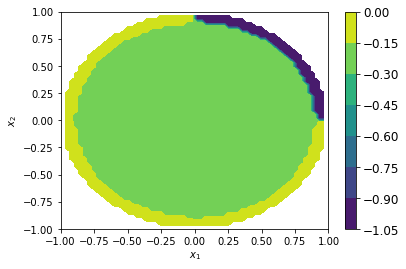

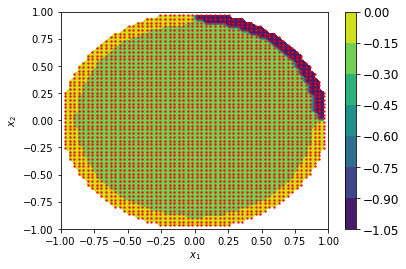

In [4]:
MC_samples = 100
nn = 60
delta_control = 0.9


# Locations for bandits
xx = onp.linspace(-1, 1, nn)
yy = onp.linspace(-1, 1, nn)
XX, YY = onp.meshgrid(xx, yy)
X_positions = onp.concatenate([XX.flatten()[:,None], YY.flatten()[:,None]], axis = 1)

# find the valid locations
R = onp.sqrt(X_positions[:,0]**2 + X_positions[:,1]**2)
X_positions = X_positions[R <= 1]

# Draw training data from functions
Y_data = onp.ones((X_positions.shape[0], 1))
for k in range(X_positions.shape[0]):
    Y_data[k, 0] = wheel_function(X_positions[k,0], X_positions[k,1], delta_control)


# Normalize the data
#Y_data = (Y_data - np.mean(Y_data)) / np.std(Y_data)

Y_data = onp.tile(Y_data,(1, MC_samples))
Y_data = -Y_data
print(Y_data.shape)


xs = X_positions

sigma = np.sqrt(1e-6) 
T = 100

# Plot the first snapshot as the data
Y_data_plot = griddata((X_positions[:,0], X_positions[:,1]), Y_data[:,0], (XX, YY), method='linear')


plt.figure(-2, figsize = (6, 4))
fig = plt.contourf(XX, YY, Y_data_plot)
plt.colorbar().ax.tick_params(labelsize=12)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
#plt.axis('square')

plt.figure(-1, figsize = (6, 4))
fig = plt.contourf(XX, YY, Y_data_plot)
plt.plot(X_positions[:,0], X_positions[:,1], 'r.', ms = 3, alpha = 0.8)
plt.colorbar().ax.tick_params(labelsize=12)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
#plt.axis('square')


Y_data = np.asarray(Y_data)
xs = np.asarray(xs)


0
[ 937 1597  871]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


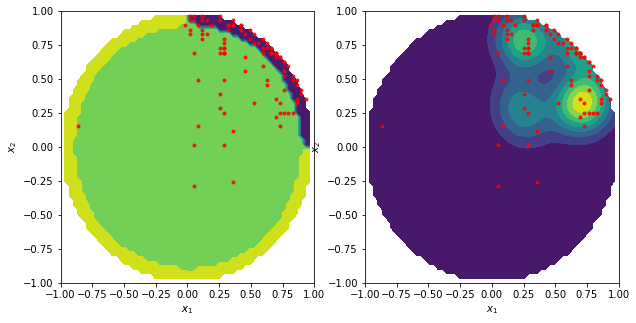

[2459 1137 1205]
[2130 1298  534]
[1833 1668  930]
[2407 2383 1633]
[1427  320 1271]
1
[2341  590  647]


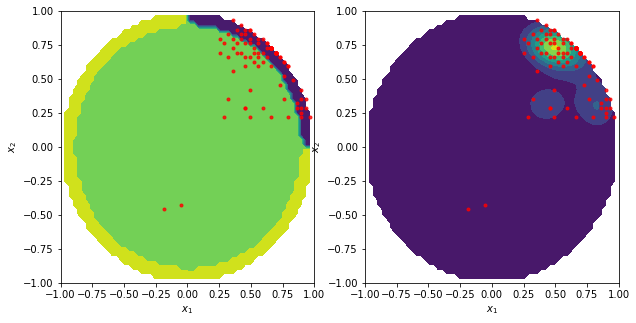

[1783 2169 1929]
[2479 1213 2003]
[ 565 1531  916]
[1263 1599 2346]
[1734 1848 2159]
2
[2404 1337 2409]


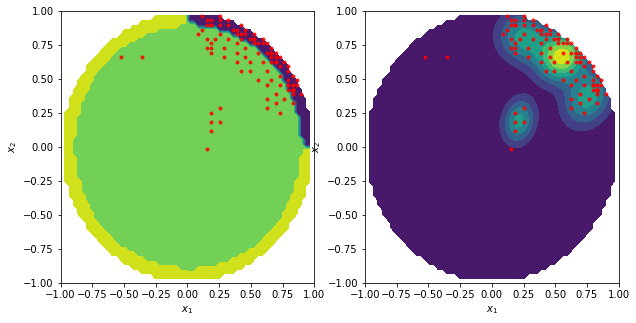

[1034  803 2121]
[ 268 2457  531]
[356 447 635]
[2368 1657 1971]
[1778  976 1467]
3
[585 386 909]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


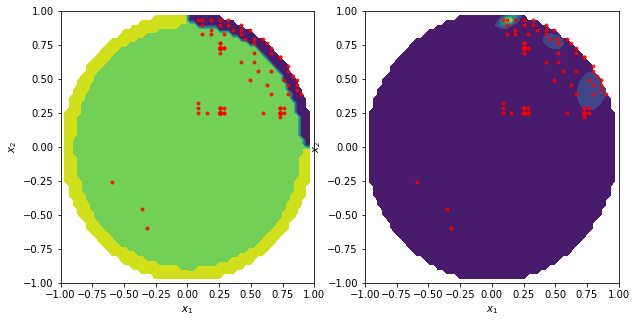

[1694 2227 1929]
[627 919 155]
[1328  106 2546]
[2359 2059  770]
[177 260 540]
4
[1009 2064 2389]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


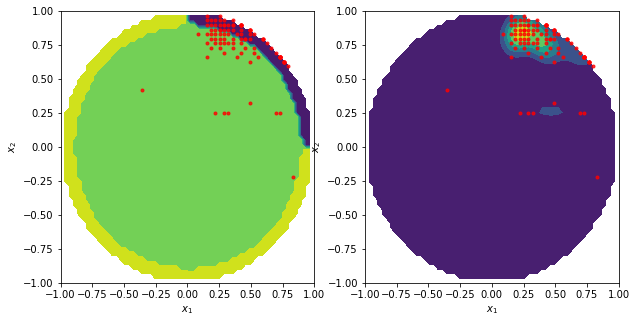

[2572  245  450]
[2642  443  496]
[2468 1407 1915]
[  83 2074 2121]
[ 773 1289 2421]
5
[ 400   49 2016]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


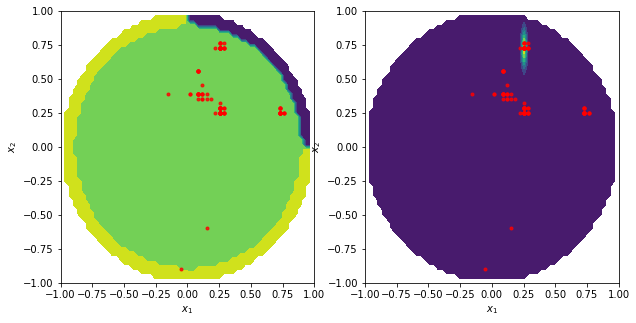

[ 736  445 1374]
[1425 1815  667]
[ 796 2113  944]
[ 267 1555 2281]
[ 359 1900  987]
6
[ 724 1388 1219]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


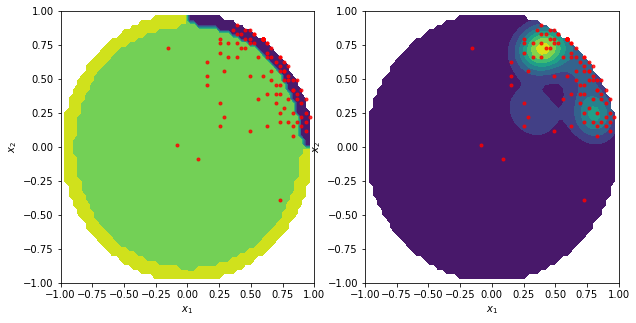

[ 491 2316 1330]
[1160  693  923]
[1953  248   50]
[2503  712  965]
[2037 1212  454]
7
[1216  405  879]


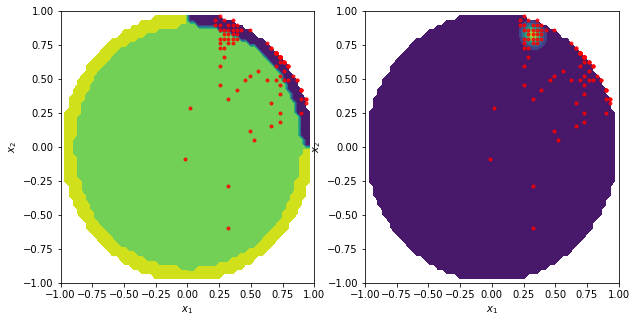

[ 501 1745 1335]
[1933 1636  760]
[1945  928  380]
[251 534 708]
[2604 1792  850]
8
[2542 2511 2172]


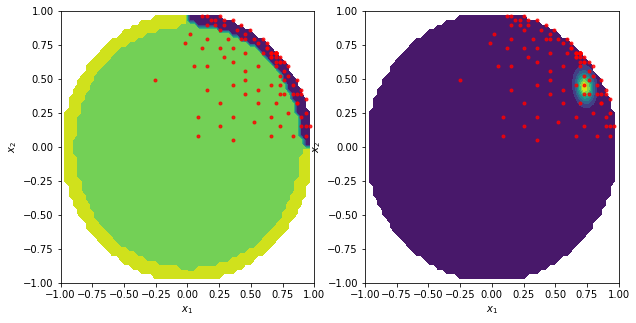

[1401 1297 2619]
[1621 1575 2016]
[1840  256  301]
[ 172  609 2277]
[1557  632  671]
9
[2388 1462 1845]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


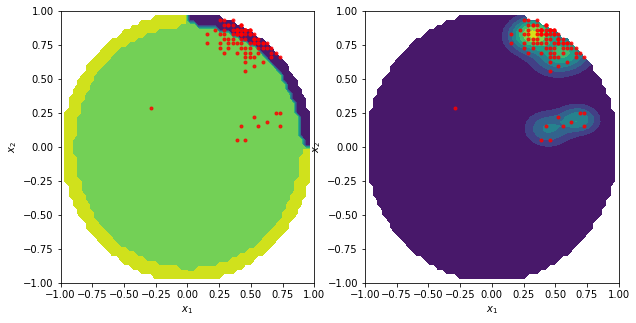

[ 358 2275 1641]
[1641 1746  646]
[1100 2418 2648]
[ 695 2214 1566]
[2231 1163  963]
10
[2518 2218 1632]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


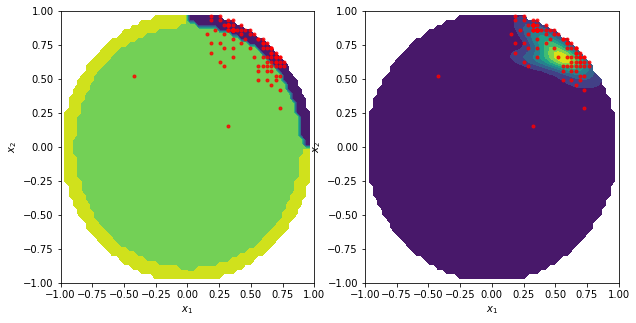

[1954 1222  254]
[1572 1638  189]
[2072  142 2606]
[1947  294  485]
[ 490 1854 2464]
11
[ 508 2023 1183]


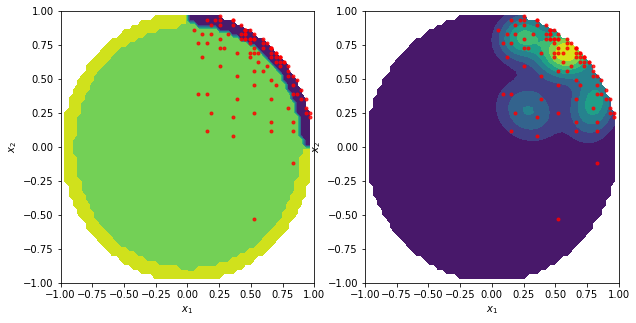

[1167 1960 1385]
[ 908 2116 1781]
[1271  755 2608]
[1553 2409  500]
[ 971 1917 2298]
12
[2077 1512  610]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


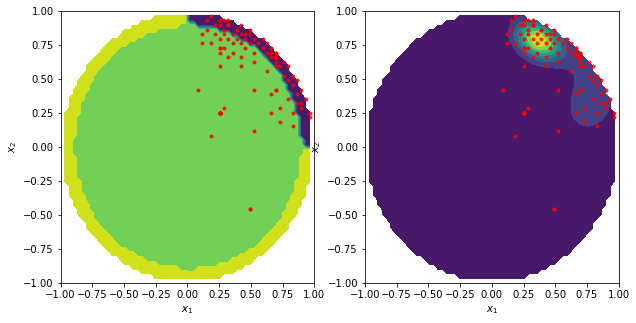

[1228 1898  386]
[1470  358 1412]
[ 984  343 2393]
[1121 1175  704]
[1430 2374 2150]
13
[ 562 2437  117]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


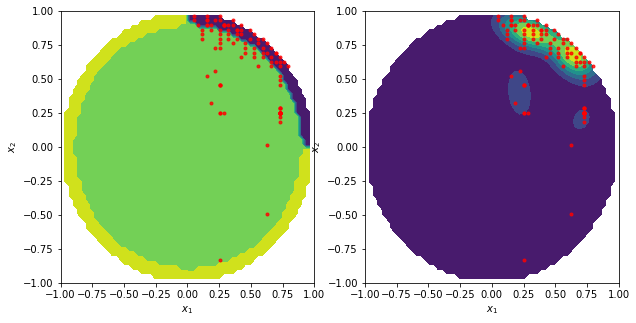

[1574 2645 1601]
[1901 1184  338]
[ 833 1043  450]
[ 753  609 2570]
[ 356 1103  247]
14
[2128 1023  192]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


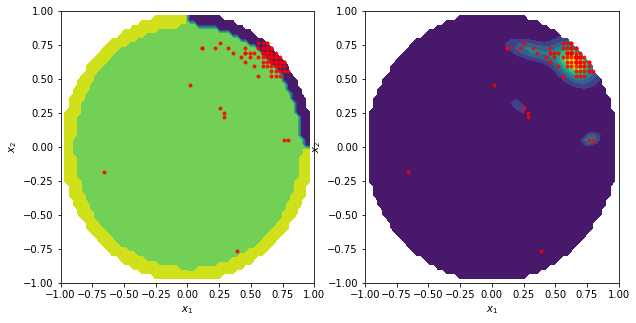

[ 750  145 1466]
[ 714 1780 1324]
[2082 1791 1221]
[ 173  313 2021]
[ 576 1312 1562]
15
[ 175  658 1693]


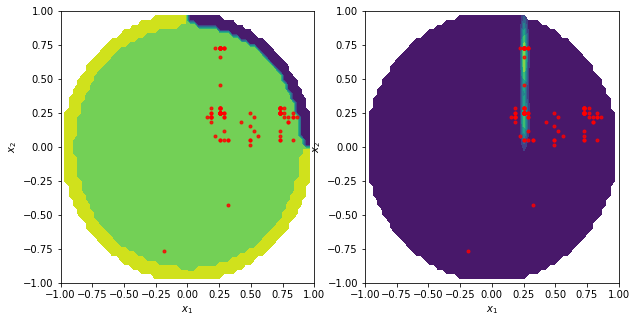

[2284 2672  319]
[ 671 1177 2176]
[1606 1876 1230]
[ 594 1142  941]
[ 577  924 1037]
16
[2292 1058 1836]


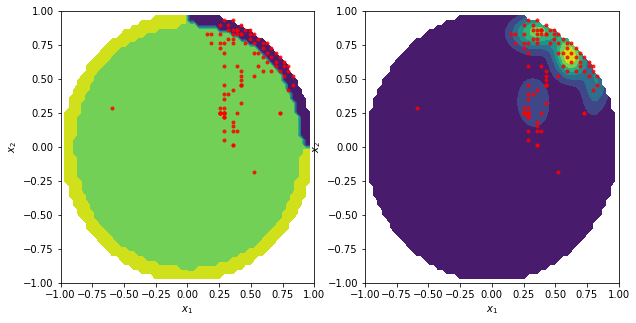

[966 169 310]
[ 109 1732 1741]
[ 109 2173 2531]
[  72 1140 1410]
[1808 1989  222]
17
[ 652 2136  291]


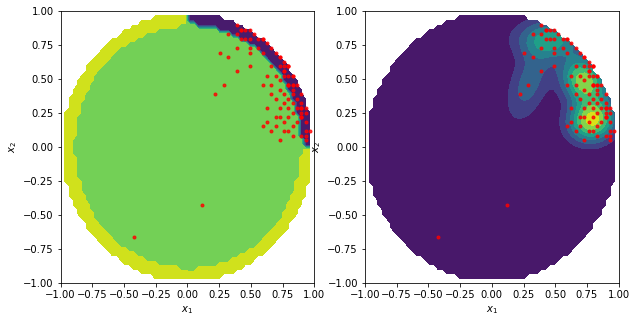

[ 212 2178 1804]
[1216  277 2321]
[ 343  339 1860]
[ 459 1782  154]
[1342 2002 1092]
18
[1391 1191  821]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


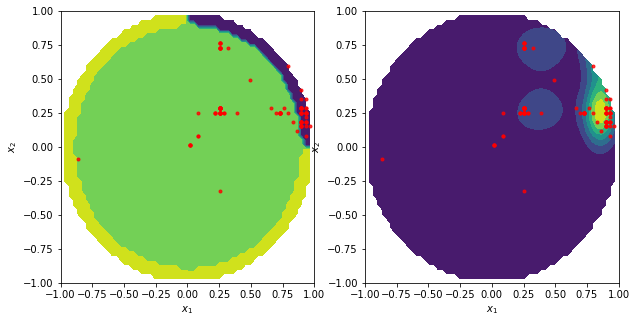

[2290 1164  994]
[ 812 2391  173]
[2476 1229 1191]
[2497 1737 1572]
[ 988 1975  311]
19
[1698 2056  380]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


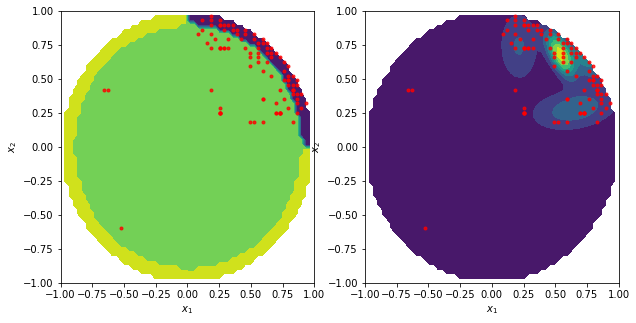

[ 272 1999 1317]
[1839 1863 2300]
[ 679 1255  790]
[ 653  716 2198]
[1182 2160 1340]
20
[2381 1724 1292]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


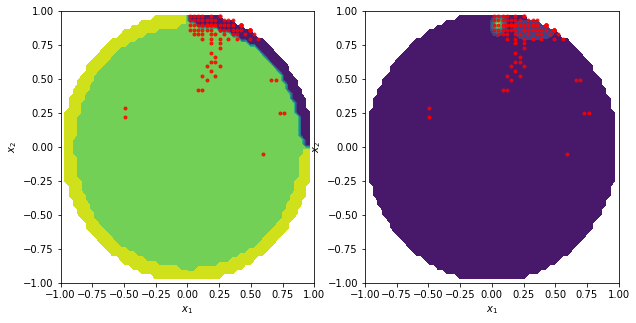

[ 693  524 2290]
[2056  304 2167]
[1199  917  223]
[ 612  367 1206]
[1386  501  615]
21
[ 301 1559 1539]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


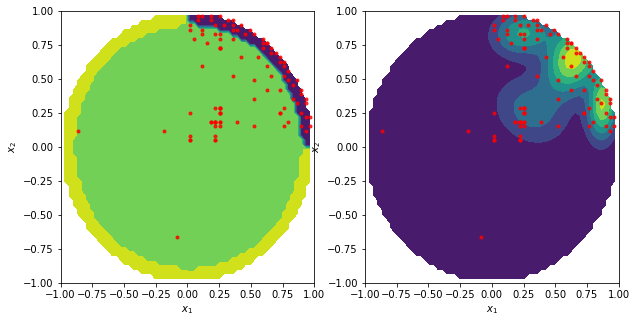

[ 335 1028   72]
[ 703  581 1309]
[2037  628 1166]
[1266 1009 1207]
[ 154 2179  592]
22
[ 509  906 2105]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


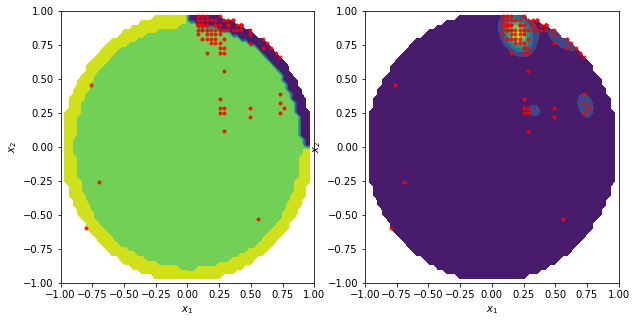

[1406  834 1818]
[ 104  299 1552]
[581 341 653]
[2405 1227 2384]
[1683 1459 1358]
23
[2315 2342 1432]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


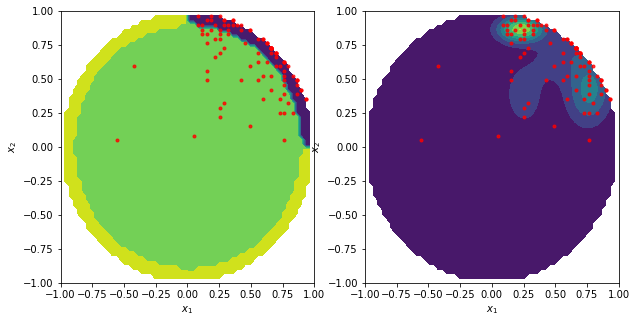

[ 301 2095 1588]
[ 576 1790  436]
[1999 1697 1233]
[741 453 501]
[2575 1635 1878]
24
[1323 2316 1616]


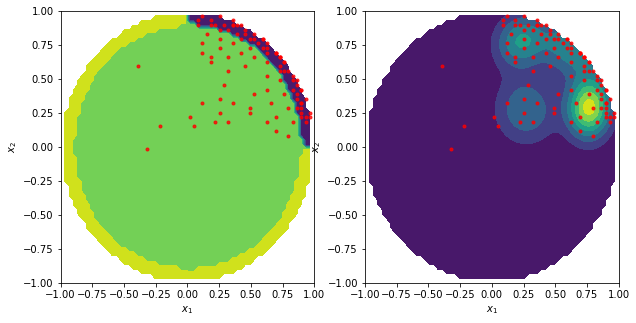

[  84 1018  503]
[ 761  887 1461]
[1839  479 1125]
[2413  639  821]
[1055 2289 1264]
25
[2298 1271  500]


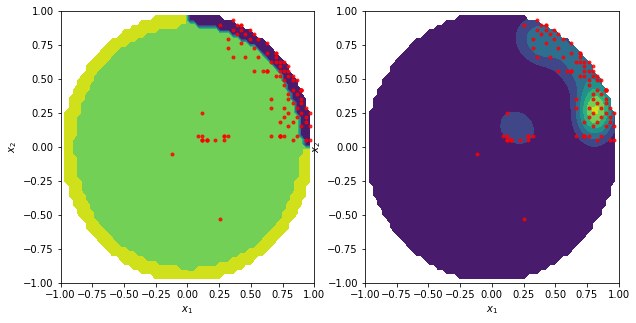

[ 216 1197  224]
[1801  343  172]
[2611  684 1625]
[2384 2472  483]
[ 600 1556  541]
26
[1545  349 1319]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


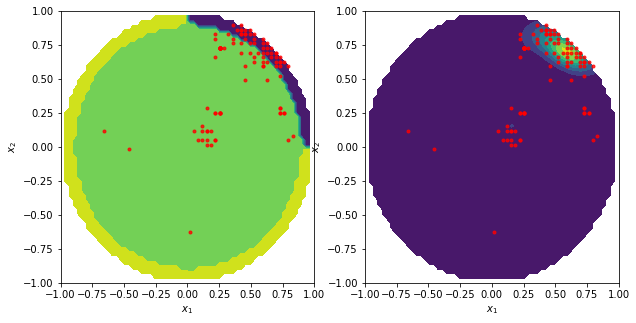

[2122 2288 2164]
[ 565 1042 1291]
[ 380 1380  463]
[1531 1145  936]
[998 608 404]
27
[2218  712 1860]


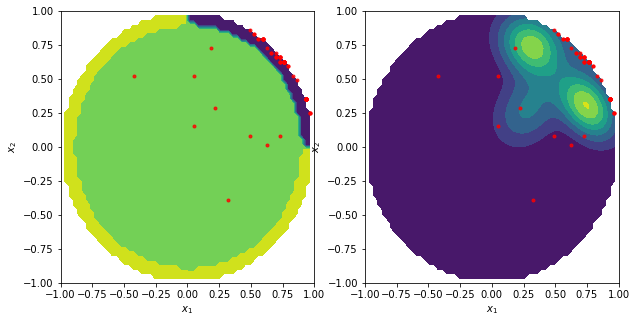

[ 589  184 2457]
[ 439  330 1912]
[2340 2326  172]
[2613  939 2466]
[ 415  806 1035]
28
[1898 2004  349]


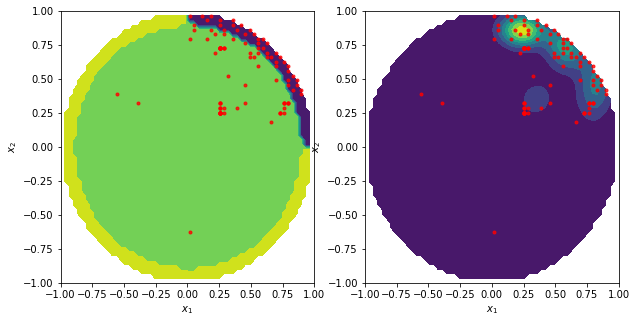

[ 721 1465 1577]
[2145  266 1139]
[1588 1161  576]
[2550 1774  264]
[2488 2083 2590]
29
[ 925  390 2169]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


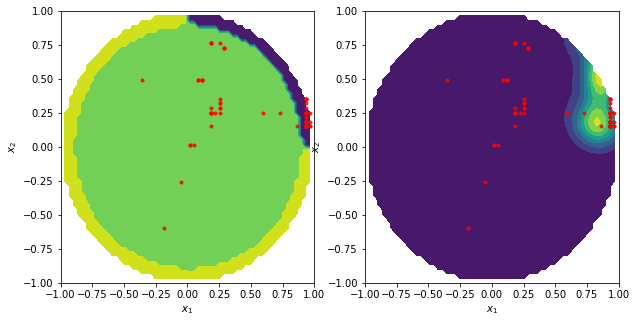

[ 449 2447 2137]
[2554  302 2642]
[1932  364 1982]
[1277 2619 2259]
[1017  288  890]
30
[1440  454 1057]


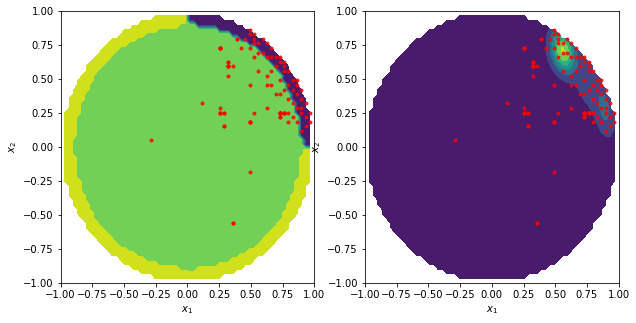

[ 523 1306  831]
[2270 1919  937]
[ 167  856 1234]
[  51 1376 1337]
[ 211 1001  535]
31
[2033 1458 2608]


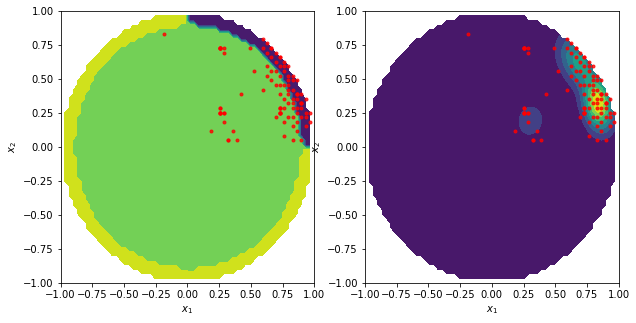

[1810 2437  914]
[2448 2648 2232]
[2414  252 2402]
[2297 1096  592]
[1078  876 2245]
32
[ 225 1139  413]


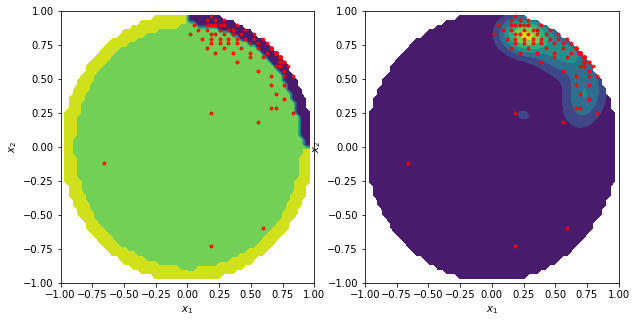

[1026  995 1509]
[873 245 504]
[946 262 964]
[1028 1618  359]
[ 996  655 1566]
33
[ 644  871 1511]


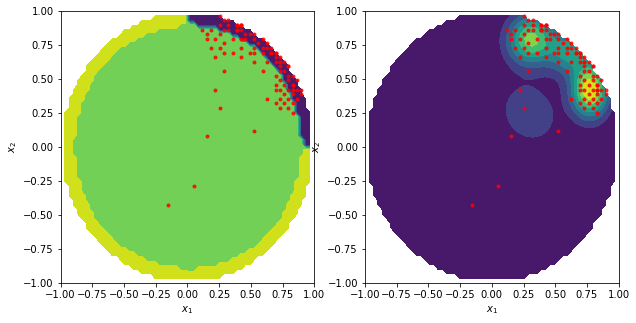

[2465  858 1499]
[2191  772  983]
[2139  608 2553]
[ 634 2248 1215]
[1109 1173 1773]
34
[ 78 694 431]


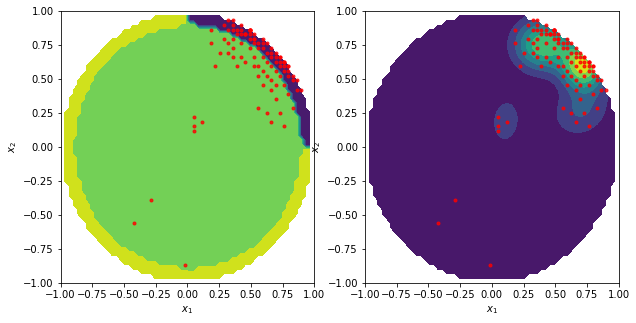

[1192 1346  705]
[2360 1481 1211]
[1366 2387 2373]
[1696  707 2364]
[2138 2171 2227]
35
[2232 1755 1202]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


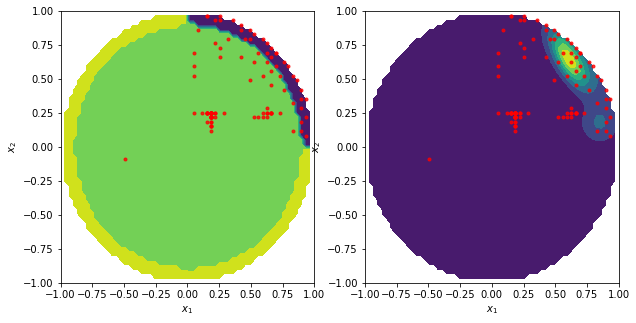

[1365 1572 2083]
[1577 2242 1566]
[1199 1682 1630]
[1177  794 2071]
[ 655  805 2308]
36
[2234  738  226]


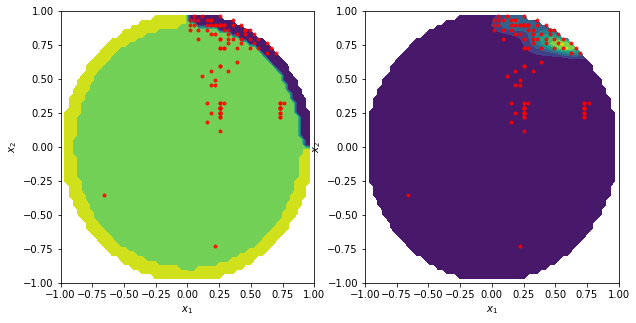

[1167 1922 1180]
[115 913 363]
[1728 1970 1865]
[ 117 1724 2519]
[1764  973 1569]
37
[2226 1971 2291]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


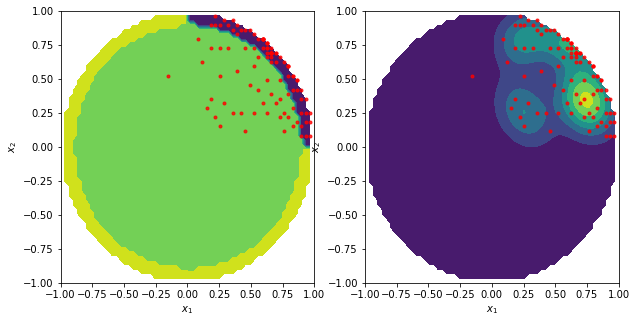

[2065  451 2297]
[740 835 501]
[2219  112 1379]
[1805  948 2034]
[2178 1266 1852]
38
[2300  438  715]


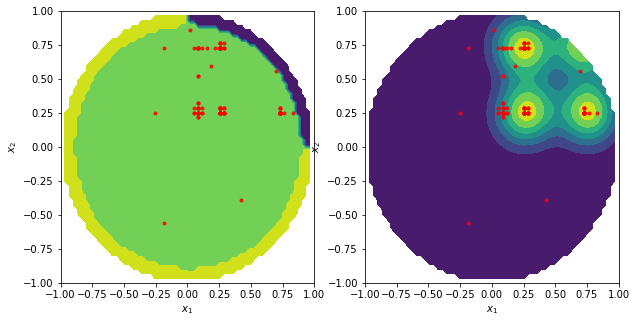

[ 167 1772  830]
[2465 2060 2548]
[2078 2001  509]
[ 453 2548  607]
[1733 2297 2082]
39
[1344 2267 2055]


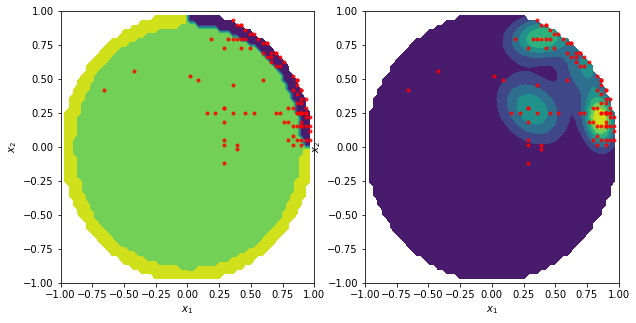

[2150 2516  747]
[1220 1355 1472]
[1326  990  587]
[1231 1663 1859]
[2465 1970  920]
40
[1193 1162 2029]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


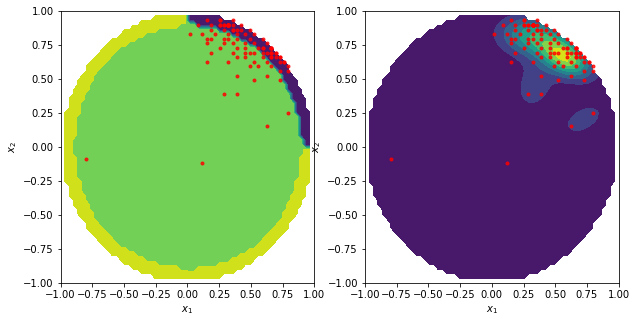

[1098 1556  602]
[1539 2449 1918]
[ 744  891 1948]
[1426  661  286]
[1107 2308 2139]
41
[1372  657  498]


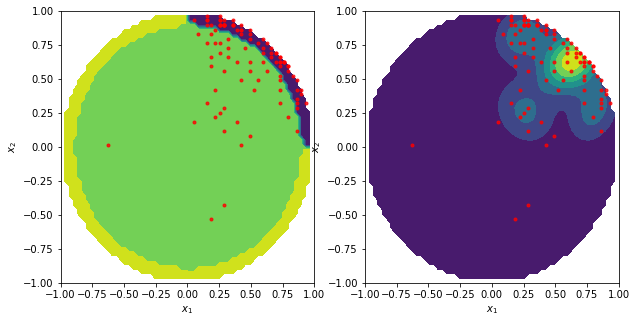

[ 452  696 2267]
[ 490 1583  641]
[1375 1669  271]
[654 443 222]
[2159 1101 1519]
42
[1725 1713  348]


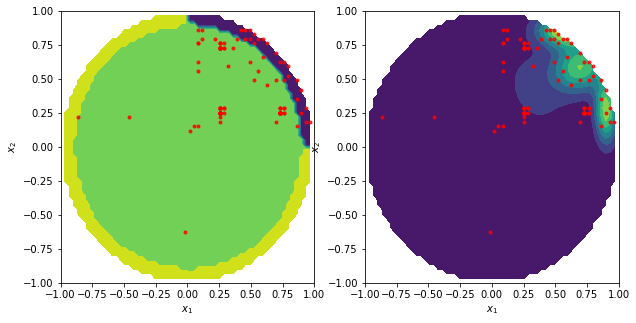

[ 642 1664  254]
[1448 1229 1759]
[ 271  997 1145]
[1365 1606  292]
[1727 2643 2463]
43
[ 827  862 2530]


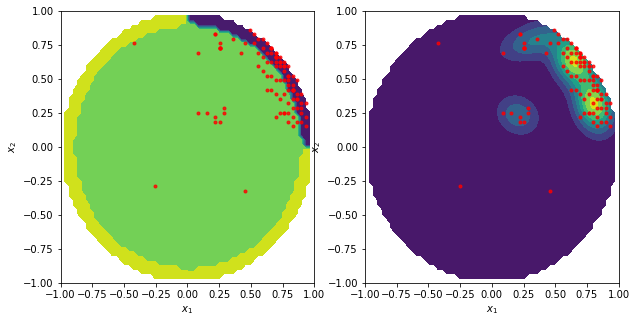

[1104  376 2513]
[2168 1716 1696]
[2575 1516  321]
[1048  654   77]
[1979 2535  742]
44
[2509  501 1349]


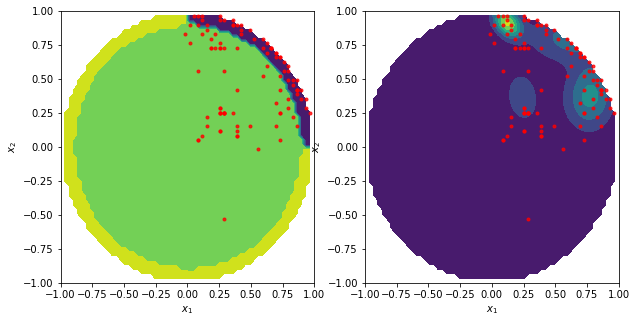

[ 747 2462  748]
[2115  223 2124]
[ 179 1637  618]
[2271 1090  941]
[1548 1803 1730]
45
[ 903 1517 2322]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


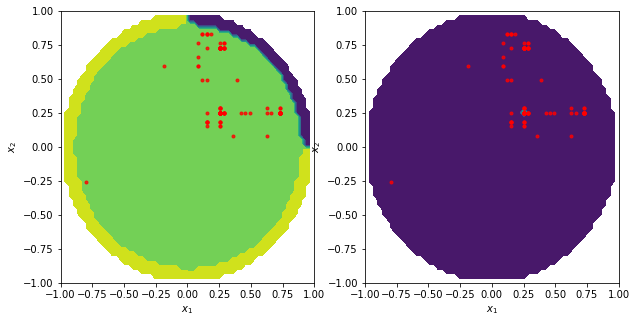

[1799  598  476]
[2269 2475 2108]
[ 527 1843  143]
[ 921 1635 1471]
[ 310 2575  699]
46
[1692 1488 1299]


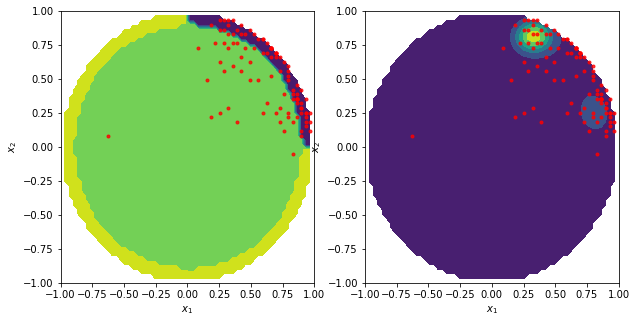

[1657  753  509]
[1617 1398 2584]
[1311 1394  828]
[2415 1642 2105]
[1079  595 1321]
47
[1251  228  578]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


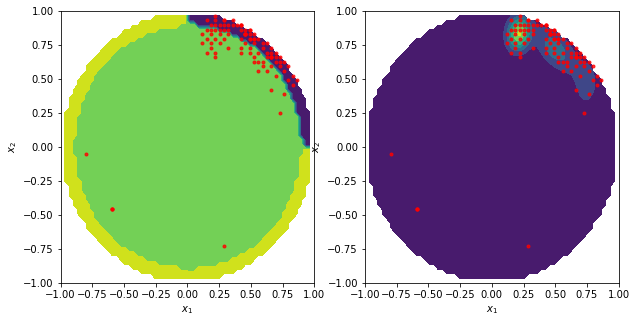

[ 603 2642  927]
[1614  305 1333]
[ 188  548 1560]
[1814  531 1545]
[1256 1548  919]
48
[2644 1436  636]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


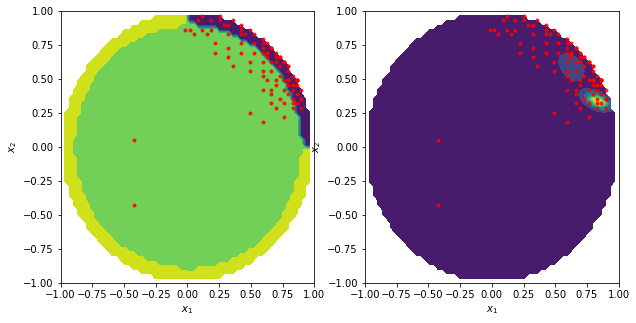

[ 902 1576 1510]
[2062  984 2446]
[1404 1669 2338]
[2286 1020  412]
[2163 1161 1546]
49
[2237 2081 2383]


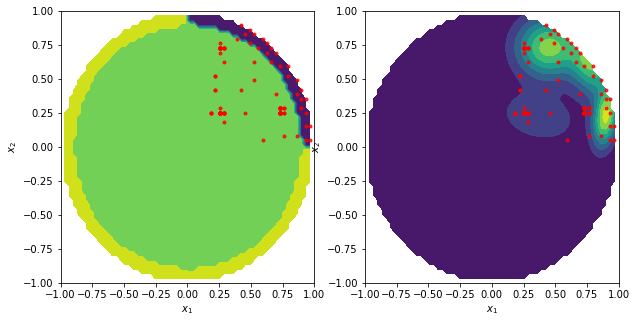

[ 540 1676 1008]
[ 226 1750 1366]
[ 763 2224 1484]
[1628  998  750]
[1658 1325 1148]
50
[1356 1715 2587]


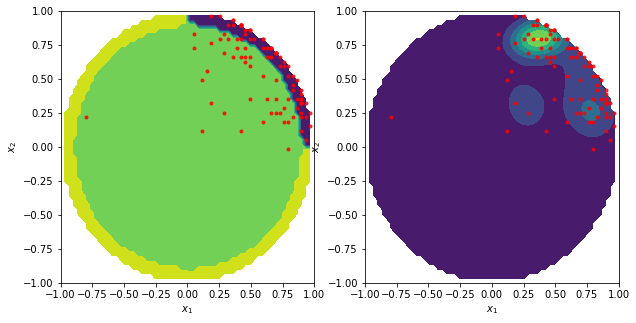

[  75  350 1556]
[ 133 2003  277]
[2125 1680 2584]
[2228 2192 2135]
[2031 2427 1215]
51
[1949  746  747]


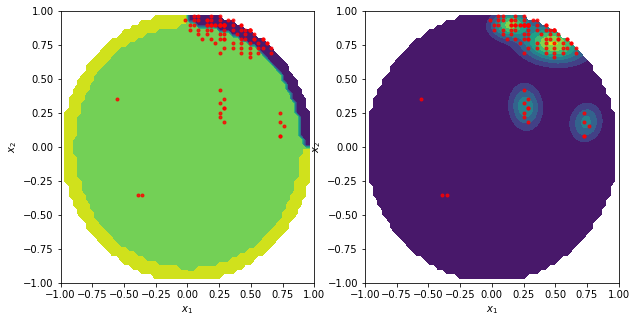

[455 260 225]
[2221  635  472]
[2591  734  488]
[1010 1440  579]
[ 444 2543 2261]
52
[2339 1450  526]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


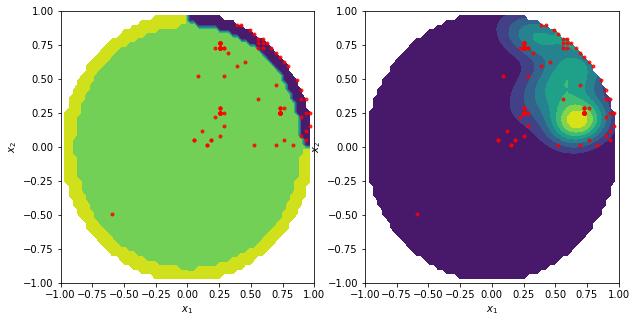

[ 340 1858  937]
[2062 2179  975]
[2464 2581 2437]
[ 922 1898 2132]
[ 332 1494 1394]
53
[1726  389 2645]


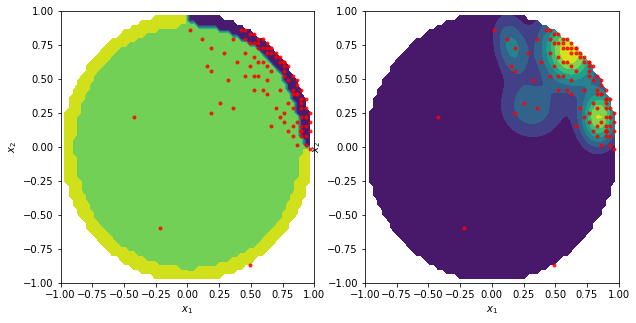

[ 143 1352  399]
[1848  777 1077]
[2555  921 1118]
[1747  822 2250]
[ 504 1000  118]
54
[1738 2671 1566]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


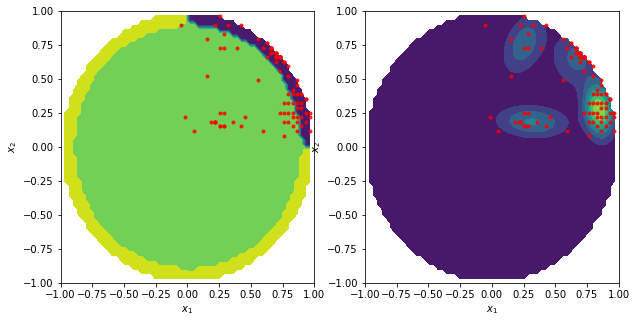

[ 719 2554 1499]
[ 978 2575  274]
[ 930  872 2390]
[1205 1043  463]
[2489 2545 1752]
55
[1355  579 2002]


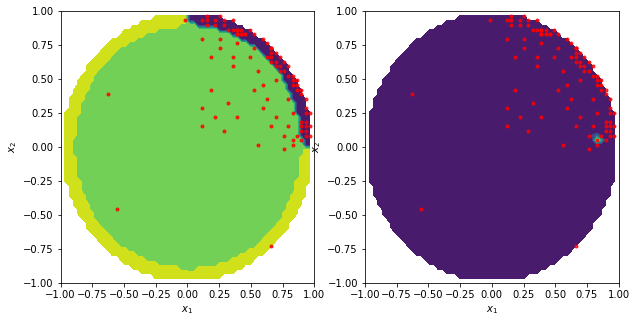

[2606 1043 1215]
[1141 1573 1081]
[1774  533 1314]
[2148 1526 2419]
[1959 1029 1327]
56
[ 386  630 2216]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


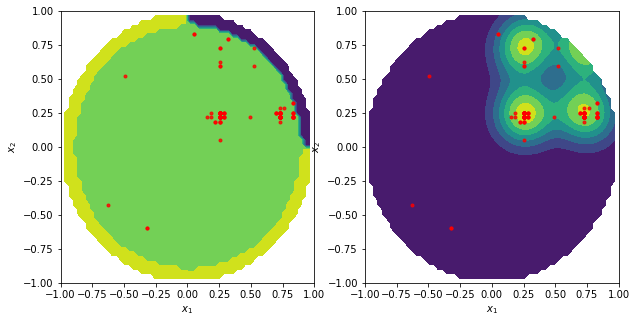

[2541 2112 1743]
[ 403 2162 1503]
[ 333 1165 1986]
[1813  463 2114]
[1726  395 1669]
57
[1501 2308 1886]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


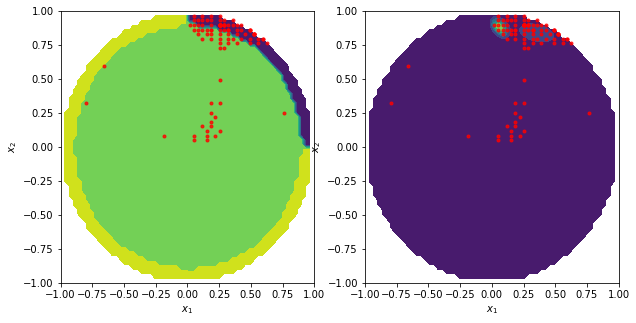

[ 827  224 1560]
[2144  682 1633]
[1834  445 1353]
[1630  649  457]
[1332 1672 1589]
58
[1218 1377  304]


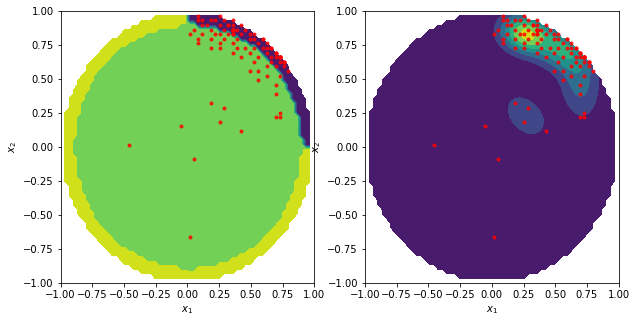

[ 892 1166 2587]
[ 593  167 1519]
[ 741 1336 2454]
[2420 1986 2260]
[1864 2024  720]
59
[ 299 1412 1610]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


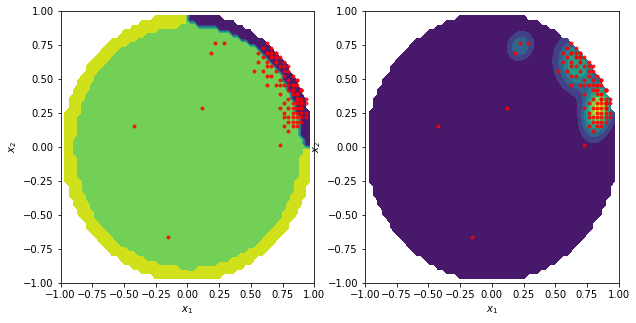

[1813 1733 2277]
[ 275 1091 1461]
[1964 1151 2466]
[1482 2096 1317]
[1693  833 2475]
60
[2496 1367 1184]


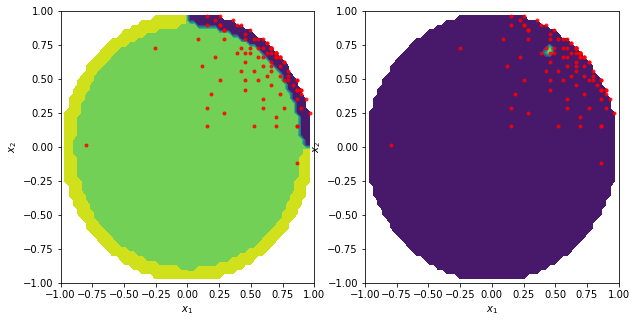

[2052 1037 1698]
[2199  931 1451]
[2529  262  317]
[2537 1948 1424]
[ 858 1988 2364]
61
[2434 1729 2118]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


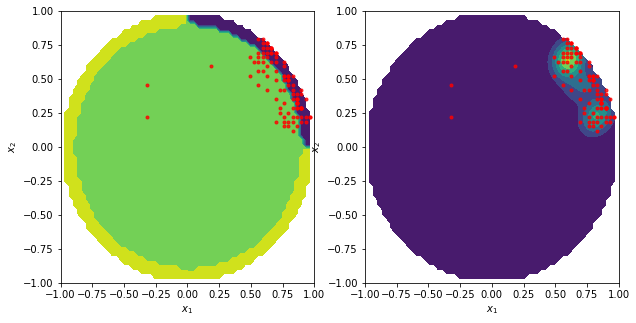

[2327 1729 1639]
[1927  644  314]
[2319 2088  489]
[1411 2235 2322]
[1473 2298 1200]
62
[447 760 668]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr

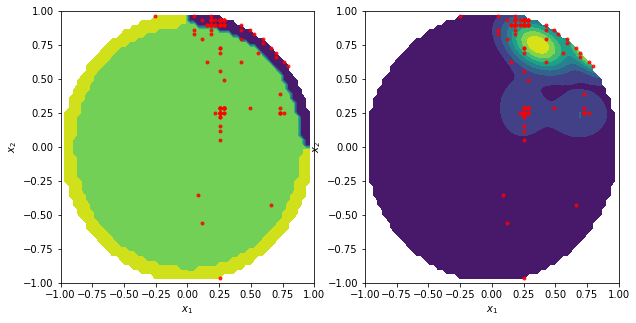

[1143 2042 1378]
[2638  710 1578]
[1956 1633  498]
[2105 2012  838]
[1333 1449  749]
63
[1229 1638 1341]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


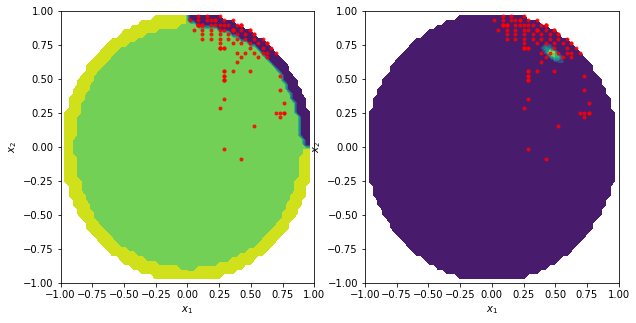

[ 219  714 1035]
[1694  961 1027]
[ 547 1760 1139]
[ 789 2166   78]
[2062 2606 1242]
64
[ 339 2420 1552]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


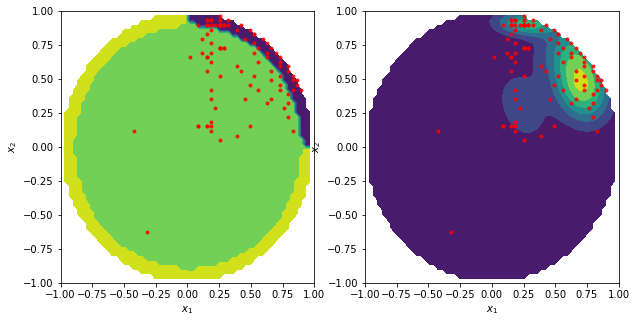

[1369  877  447]
[1521  541 1676]
[ 682 1403  186]
[1198 2215  441]
[ 683 1742  742]
65
[1126  615 1906]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


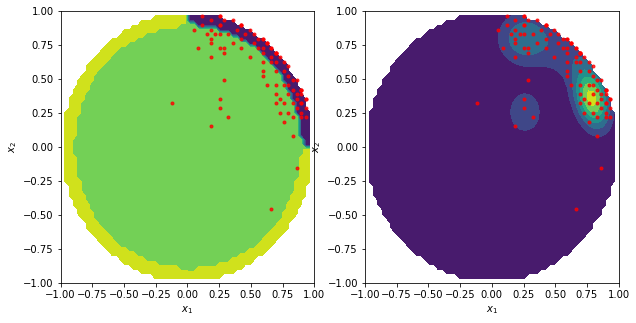

[1487 1089  337]
[1646 1314 1514]
[1577 2335 2179]
[1840  853 1253]
[2165 1606 2544]
66
[ 662  376 1548]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


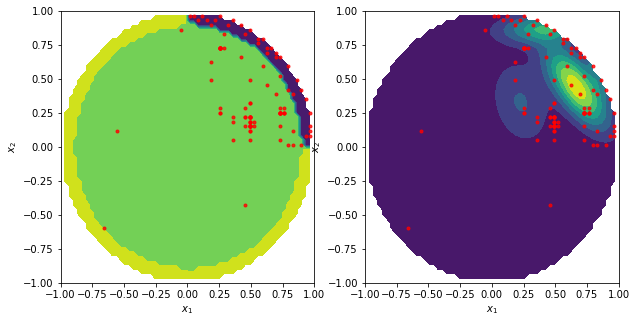

[ 288 2623 1122]
[ 891 2029 1777]
[2372  635  853]
[1901  593 2294]
[1221 1322 1504]
67
[1310 1259  603]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


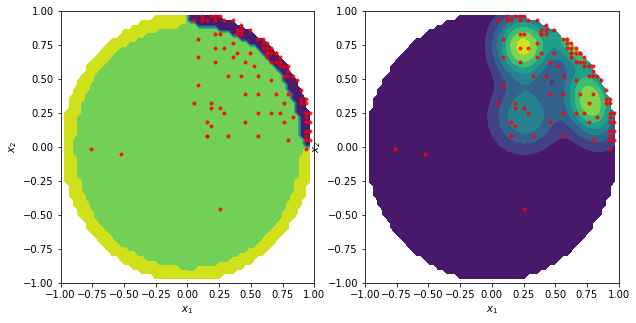

[1590 1779  438]
[ 642 1163 1615]
[1447 2252  409]
[1999  669  478]
[2105 1194 2232]
68
[1450  380  427]


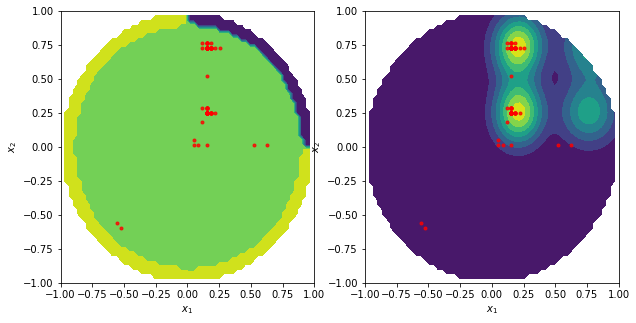

[  85  584 1726]
[1912  359 1902]
[1754 2534  917]
[1410 2535 1489]
[ 919 2260  577]
69
[ 440 2274 2172]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


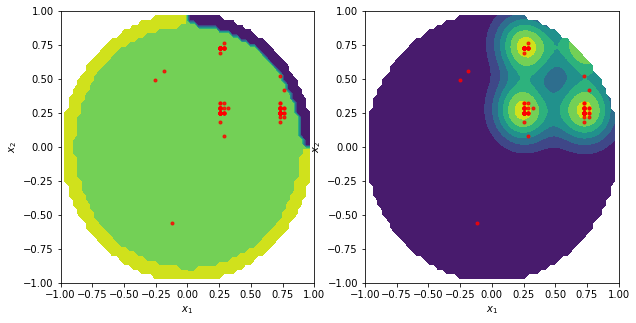

[2371 1521  904]
[ 296 2080  522]
[ 894  699 1788]
[1068  537  893]
[2511 2075 2148]
70
[533 363 814]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


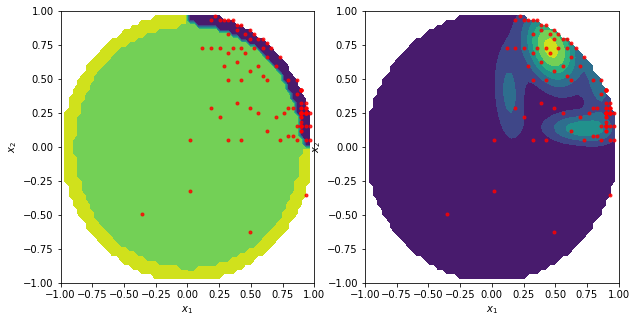

[ 856  392 2297]
[2456 2373  472]
[1393 1390 1932]
[2039  875  698]
[ 187  413 1264]
71
[2197 1907 1726]


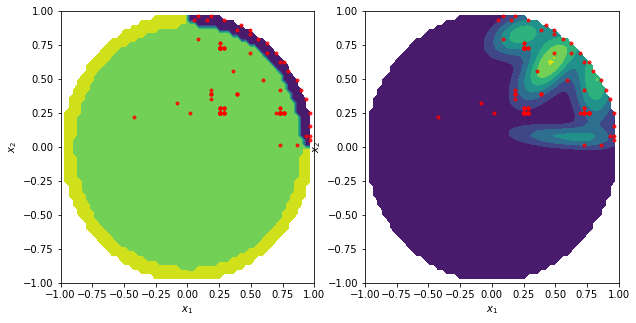

[2134 1316  685]
[ 463 2220  918]
[ 853 2578  767]
[1545  836 2337]
[1402 1931 2114]
72
[2196 2085 1998]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


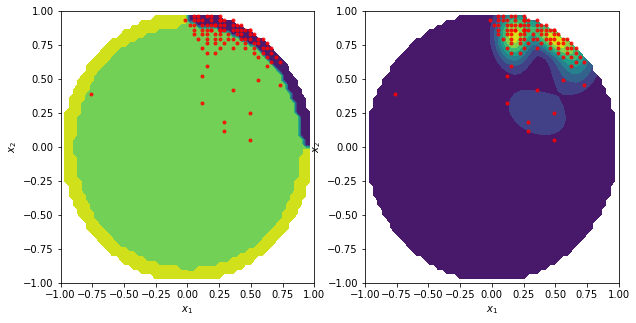

[461 813 874]
[681 979 269]
[1585 2109  991]
[ 880  377 2091]
[2429 2580 1208]
73
[1626  823 1284]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


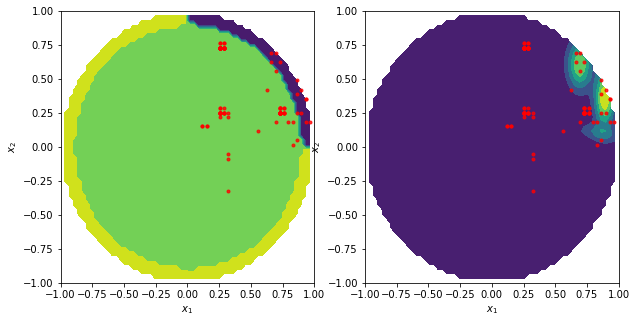

[1354  338 2236]
[2018 2025 1540]
[1747 1312 1795]
[1049 2173 1890]
[1135 2615 1154]
74
[1280  226 1184]


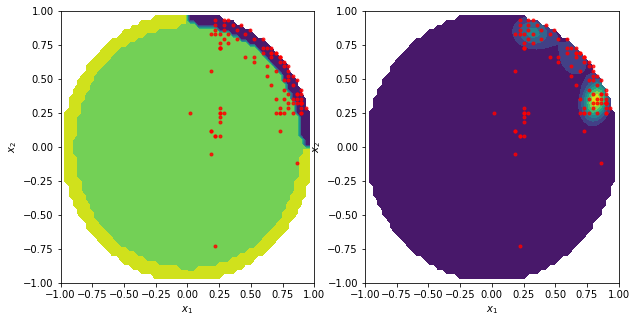

[ 178 1410 2488]
[1891 1945 2233]
[ 850 1835 2643]
[876 412 643]
[1337 1454  917]
75
[1432 1039  313]


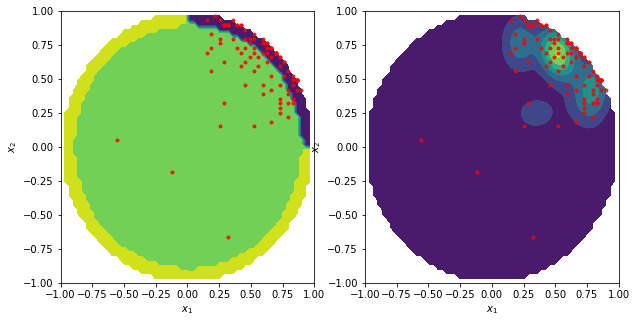

[1624 1218 1875]
[917 301 582]
[2325 1287 2290]
[ 186  533 2530]
[2554 1847 1391]
76
[1732 1022 1433]


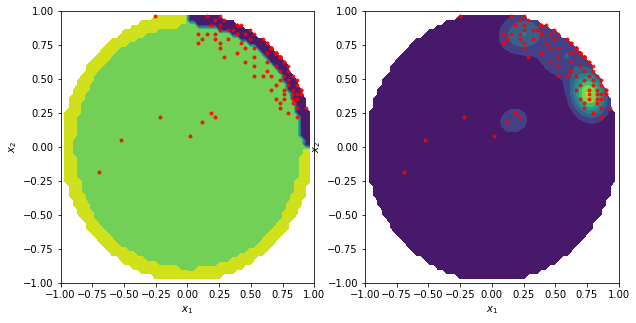

[ 614 2452  302]
[2195  815  227]
[ 336 1430 2201]
[1738  834 2386]
[ 103 1161 1701]
77
[ 464 1166 1191]


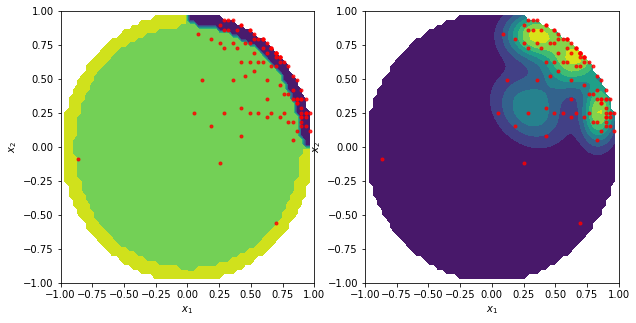

[1976 1696 2529]
[1857  965  554]
[1409  876 2217]
[ 181 1221 1620]
[2238 2623 2554]
78
[2275 1516 1866]


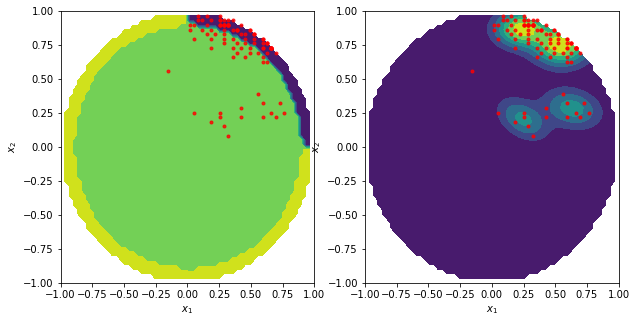

[ 741 2535 1399]
[2177 1734 1434]
[1272 2590 1325]
[1673  744  801]
[ 777 1263  312]
79
[ 816 1640  941]


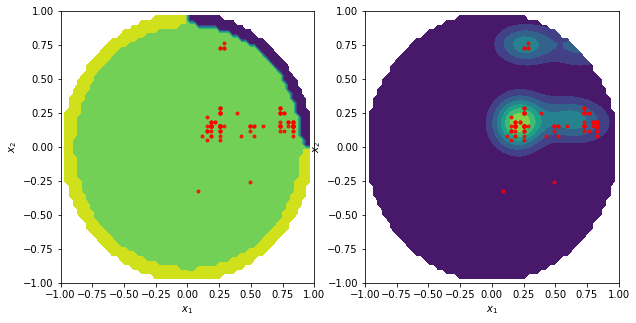

[1327  169 1080]
[1264 1631 2260]
[1833 2642  739]
[ 936 2311 2277]
[2313  793 2002]
80
[ 793  656 2015]


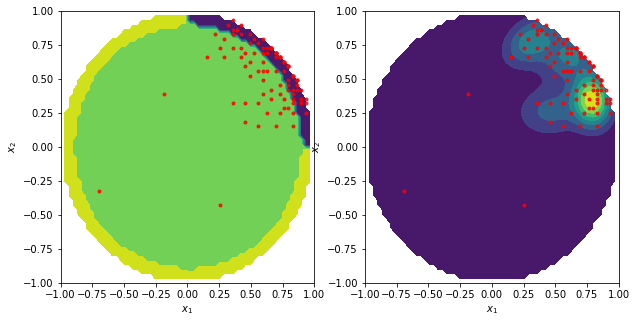

[2335 1222 1395]
[2132  959 2531]
[1348 2112 1021]
[ 410  972 1375]
[ 550  523 1242]
81
[ 538  766 1774]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr

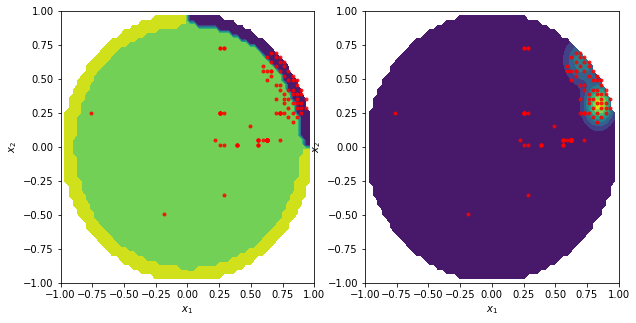

[1727 1503 2502]
[2091 2082 1297]
[ 527 1242 1873]
[2158  119 1468]
[ 918 1100 2547]
82
[2671 2457  616]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


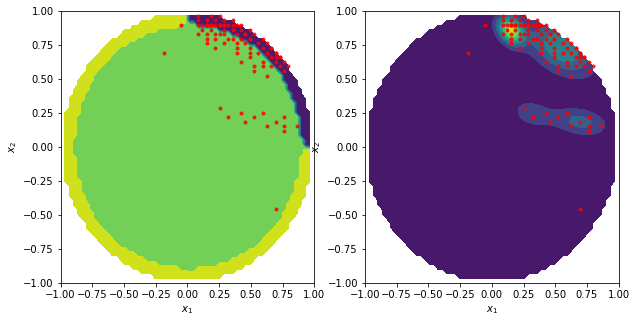

[2076 2617  888]
[1730  491 1509]
[1467  700  170]
[1747 2158  575]
[ 668  664 1472]
83
[1844 2324  588]


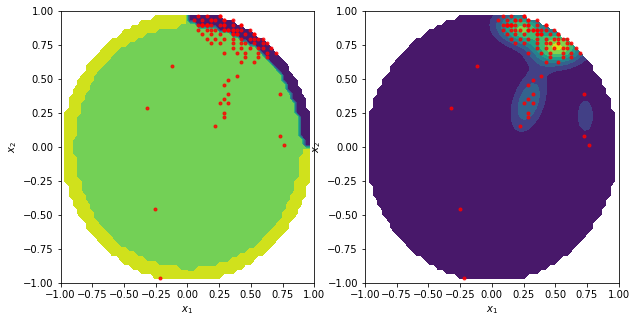

[ 423 2548 1146]
[1036 1027  589]
[212 263 442]
[1550 1512  175]
[1126  575  335]
84
[ 499 2547  986]


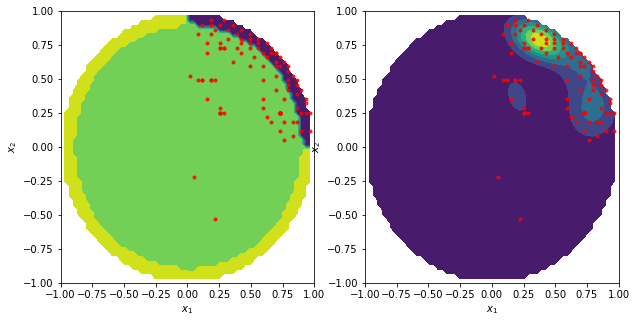

[2218 1121 1023]
[ 384 1422 1748]
[1602 1803 2209]
[ 393  902 1498]
[ 455 1389  513]
85
[1676 2225 1928]


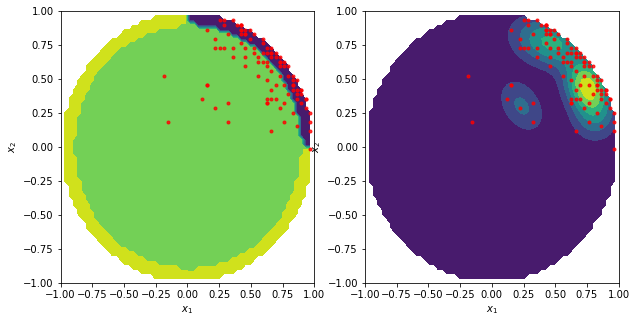

[2471 2286 1446]
[1475  831  824]
[2264 1562 1437]
[1058 2615 1313]
[2580 2006  423]
86
[2263  503  151]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


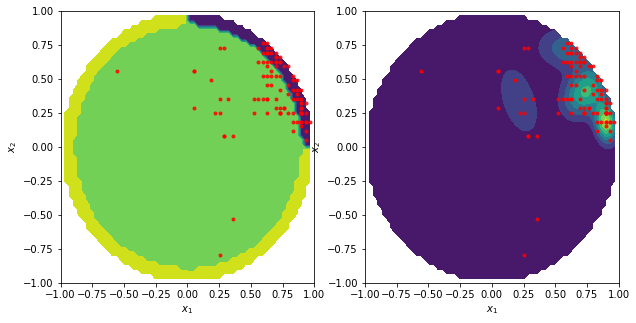

[2214 1126 2456]
[ 581 2276  307]
[2519 2377  496]
[1729 1151 1988]
[ 286 2408 2187]
87
[1841 1007  972]


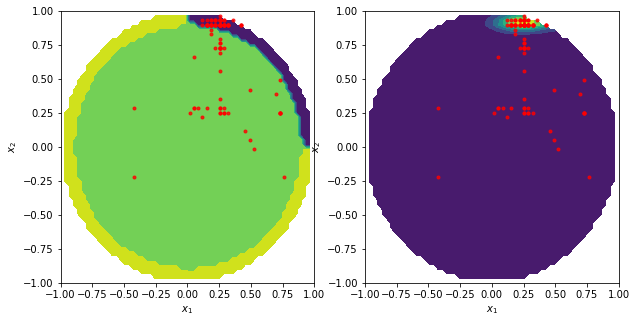

[1951 1616 1180]
[1733  704  355]
[ 794 2292 2328]
[ 708 1698  822]
[ 399 1416 2319]
88
[1207  838 1605]


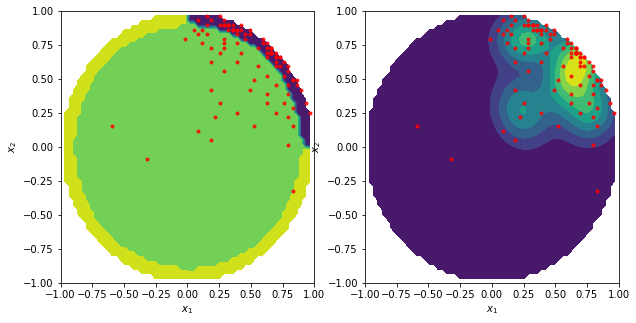

[ 781  394 2274]
[1005 1967 2514]
[887 818 552]
[2144  355  800]
[1997  701 2182]
89
[ 855 2492  235]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


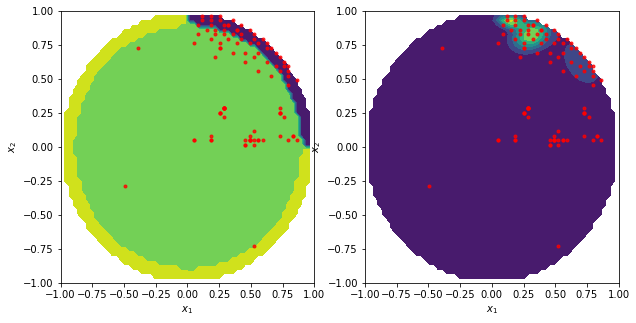

[2359 1041 2234]
[ 297 1830 2320]
[1583 1456 1627]
[1396  512 2371]
[  77  106 1847]
90
[ 438 2071 2588]


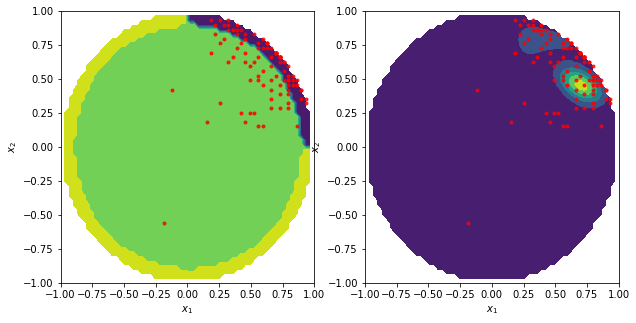

[ 294 1719 1262]
[1643 2333  529]
[1658  490  608]
[1436  721  797]
[ 888 1554  824]
91
[1253 1850  589]


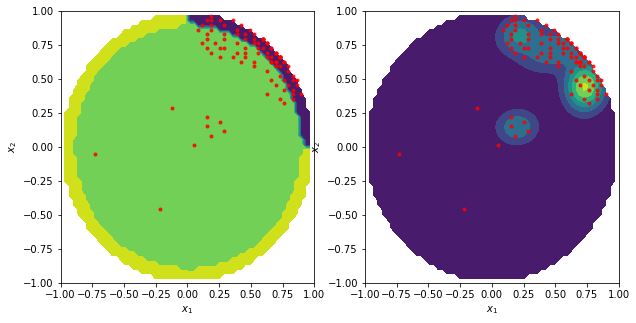

[ 824 1251  889]
[ 975 2096 1687]
[1334 2360  696]
[ 919 2093 2217]
[ 333  353 2544]
92
[ 921 2609 1951]


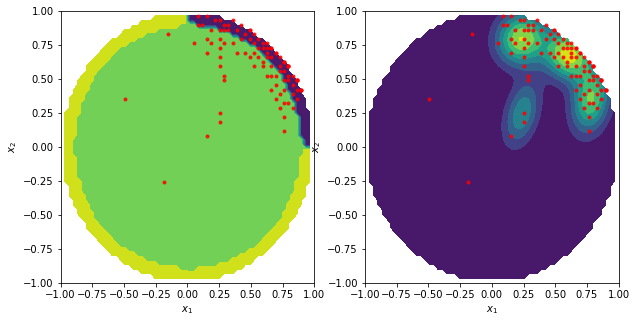

[1632 1719 2143]
[2326 1171 2494]
[  79 1396  223]
[ 514 1802 1918]
[2385 2074 1901]
93
[2569 1625 1580]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr

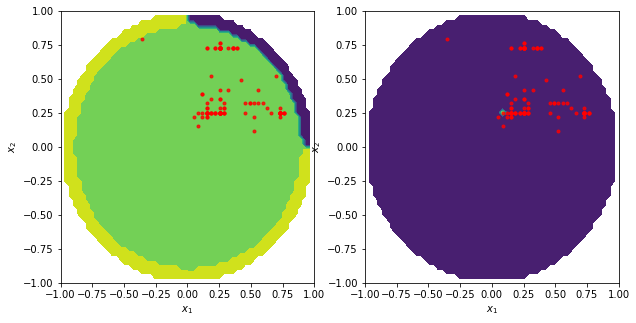

[1058 2372 1291]
[2584  916  928]
[1870 1878 2608]
[1602 1261 2028]
[ 768  213 2120]
94
[ 365 1155  112]


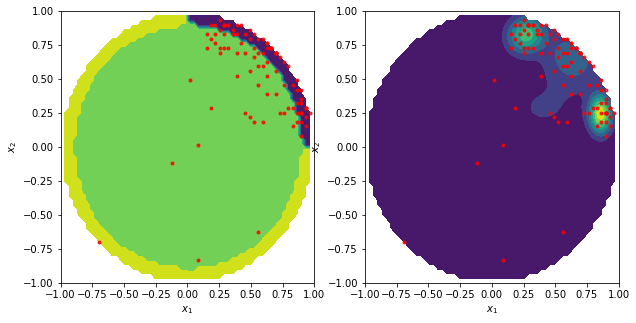

[1590 1424  879]
[ 616  734 2651]
[1119 1325 2642]
[2324  796 2246]
[1555 2108  686]
95
[2216 1230 1588]


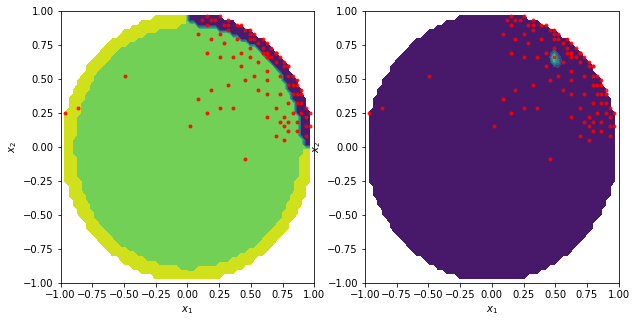

[2607 1090 1513]
[1589  892 1250]
[1061  429  967]
[2430  626 2497]
[1323 1429 2274]
96
[1784 1955  291]


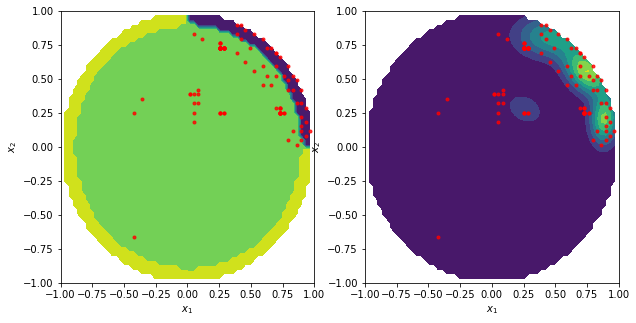

[1757 1284 1895]
[ 694  886 1114]
[ 656 2262  318]
[ 449  798 1405]
[1747  393   51]
97
[2007  532 1377]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


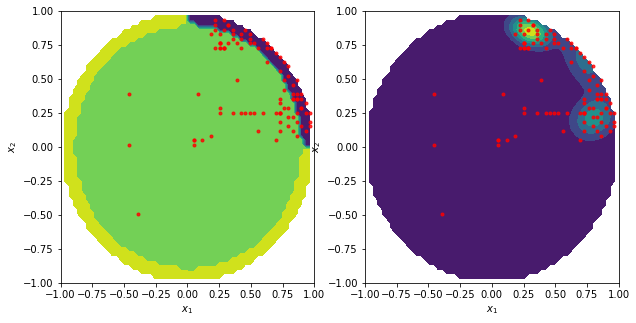

[1780 1145 1774]
[941 399 745]
[1942  187 1426]
[ 599  982 2118]
[ 380 1281  528]
98
[971 806 922]


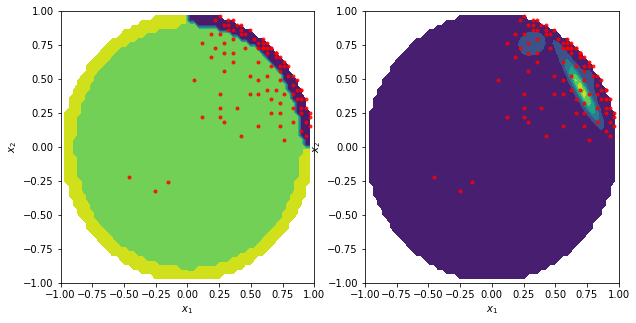

[1906 2170 1351]
[2014 1682 2079]
[1423 1713 1834]
[ 816 1024 1644]
[1306 1372 1319]
99
[2326 2293 2121]


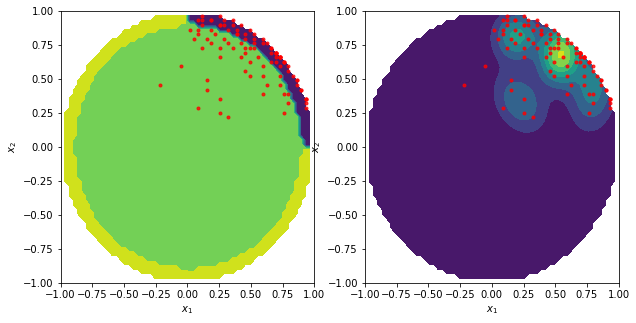

[ 781 1010  535]
[ 802 1089 2183]
[ 364 1367 2472]
[1750 1213 1276]
[ 708  866 1546]
(100, 100) (100, 100) (100, 100) (100, 100) (100, 100) (100, 100) (100, 102, 2) (100, 102, 2) (100, 102, 2) (100, 102, 2) (100, 102, 2) (100, 102, 2) (100, 60, 60)


In [5]:
model = run_simulations(Y_data, xs, sigma, T, MC_samples, XX, YY, Y_data_plot, nn, delta_control)
regrets_LCB, regrets_LCB_v, regrets_mean, regrets_TS, regrets_EI, regrets_LW_LCB, \
X_LCB, X_LCB_v, X_mean, X_TS, X_EI, X_LW_LCB, Weights_LW_LCB = model.train()

np.save("regrets_LCB", regrets_LCB)
np.save("regrets_LCB_v", regrets_LCB_v)
np.save("regrets_mean", regrets_mean)
np.save("regrets_TS", regrets_TS)
np.save("regrets_EI", regrets_EI)
np.save("regrets_LW_LCB", regrets_LW_LCB)

np.save("X_LCB", X_LCB)
np.save("X_LCB_v", X_LCB_v)
np.save("X_mean", X_mean)
np.save("X_TS", X_TS)
np.save("X_EI", X_EI)
np.save("X_LW_LCB", X_LW_LCB)

np.save("Weights_LW_LCB", Weights_LW_LCB)




